In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gplately
import pandas as pd

%matplotlib inline

reconstruction_times = np.arange(0,171)

agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = agegrid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"

In [2]:
# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Clennett2020")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [3]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0 #Ma
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [4]:
subfz_raster = gplately.Raster(filename="subducted_fz_ages.nc")


In [5]:
metal_dict = dict()

commodities = ['Cu (Mt)', 'Pb (Mt)', 'Zn (Mt)', 'Ni (Mt)']
sheets = ['PbZn-CD', 'PbZn-MVT', 'Cu-sed', 'Magmatic Ni', 'VMS', 'Cu-por', 'IOCG']

for sheet in sheets:
    df = pd.read_excel('data/base_metal_deposit_compilation.xls', sheet_name=sheet, na_values='ND')
    df = df[df['Age (Ga)'].notna()]
    df = df[df['Age (Ga)']*1000 <= reconstruction_times.max()]

    if df.shape[0] > 0:
        metal_dict[sheet] = df
    else:
        sheets.remove(sheet)
        
symbols = ['o', 'v', 's', '*', 'd', '^', 'P']*2

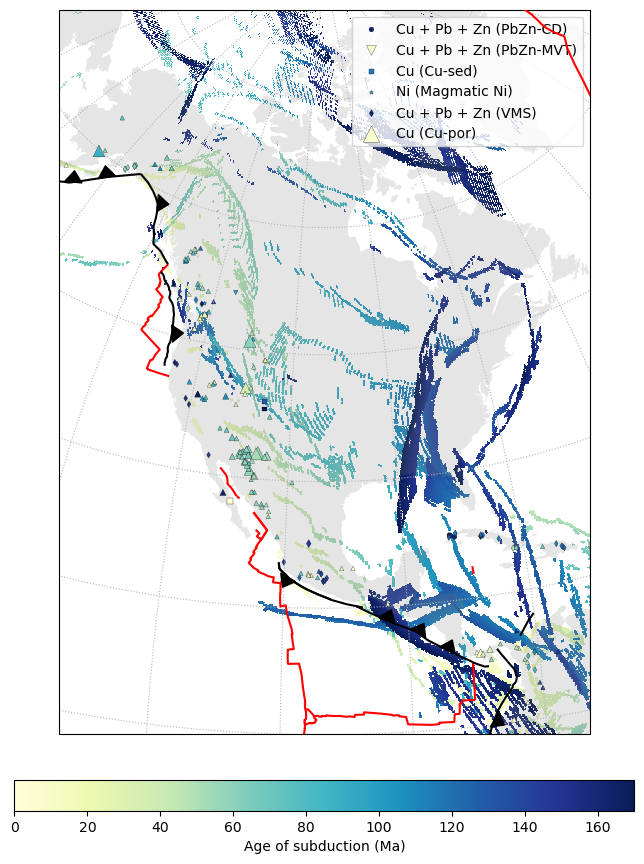

In [6]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.AzimuthalEquidistant(-100, 30))
ax.set_extent([-130, -70, 0, 85])
ax.gridlines(color='0.7',linestyle=':', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 0 # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
im = gplot.plot_grid(ax, subfz_raster.data, origin='lower', cmap='YlGnBu', interpolation='None', vmin=0)
gplot.plot_coastlines(ax, color='0.5', alpha=0.2)
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

gplot.plot_trenches(ax, color='k', zorder=9, )
gplot.plot_subduction_teeth(ax, color='k', zorder=10, )


for i, sheet in enumerate(sheets):
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    sc = ax.scatter(df['Lon'], df['Lat'], s=10+size*2, c=df['Age (Ga)']*1000, marker=symbols[i], cmap='YlGnBu',
                    vmin=0, vmax=reconstruction_times.max(),
                    label=label, transform=ccrs.PlateCarree(), edgecolor='k', linewidth=0.2)

    
fig.colorbar(im, shrink=0.5, pad=0.05, orientation='horizontal', label='Age of subduction (Ma)')
ax.legend()

Create a `gplately.Points` object for all deposits

In [7]:
pts_dict = dict()

for i, sheet in enumerate(sheets):
    df = metal_dict[sheet]

    pts_dict[sheet] = gplately.Points(model, df['Lon'], df['Lat'])

We want to reconstruct these deposits with an age uncertainty buffer that can be user-defined

In [8]:
from scipy.spatial import cKDTree
def KD_dist(lons0, lats0, lons1, lats1):
    x0, y0, z0 = gplately.tools.lonlat2xyz(lons0, lats0)
    x1, y1, z1 = gplately.tools.lonlat2xyz(lons1, lats1)
    
    tree = cKDTree(np.c_[x0, y0, z0])
    d, idx = tree.query(np.c_[x1, y1, z1])
    return d*gplately.EARTH_RADIUS, idx

In [9]:
for i, sheet in enumerate(sheets):
    gpts = pts_dict[sheet]
    df = metal_dict[sheet]
    
    print(df.shape)

(3, 16)
(18, 15)
(19, 8)
(1, 12)
(162, 8)
(428, 6)


Calculate distance between deposit and fracture zone

In [10]:
age_buffer = 5 # Ma

for i, sheet in enumerate(sheets):
    gpts = pts_dict[sheet]
    df = metal_dict[sheet]
    
    distances = np.zeros((df.shape[0], age_buffer))
    
    for a in range(0, age_buffer):
        ages = np.clip(df['Age (Ga)']*1000 - a, 0, reconstruction_times.max()).astype(int)
        rlons, rlats = gpts.reconstruct_to_birth_age(ages)
        
        with np.load("subducted_fz_data.npz", "r") as npz:
            for i, age in enumerate(ages):
                fz_data = npz[str(int(age))]
                fz_lons, fz_lats = fz_data

                dist = gplately.tools.haversine_distance(rlons[i], fz_lons,
                                                         rlats[i], fz_lats,
                                                         degrees=True)

                distances[i,a] = dist.min()*1e-3
    
    df = df.assign(distance_to_deposit=distances.min(axis=1))
    metal_dict[sheet] = df

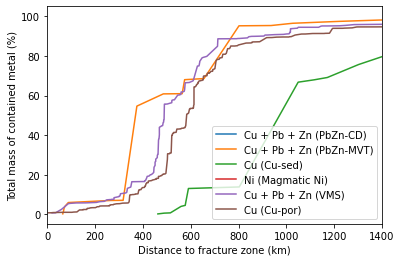

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0,1400])
ax1.set_xlabel('Distance to fracture zone (km)')
ax1.set_ylabel('Total mass of contained metal (%)')

for sheet in sheets:
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    dist = df['distance_to_deposit'].to_numpy()

    # create cumulative distribution
    idx_sort = dist.argsort()
    dist = dist[idx_sort]
    size = size[idx_sort]
    size /= size.sum()
    cumsum_size = np.cumsum(size)
    
    ax1.plot(dist, cumsum_size*100, label=label)

ax1.legend()

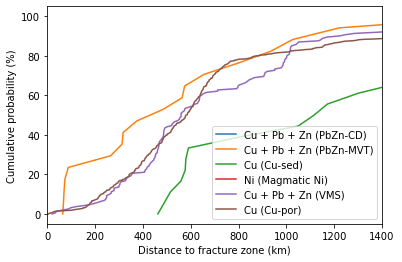

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0,1400])
ax1.set_xlabel('Distance to fracture zone (km)')
ax1.set_ylabel('Cumulative probability (%)')

for sheet in sheets:
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    dist = df['distance_to_deposit'].to_numpy()

    # create cumulative distribution
    idx_sort = dist.argsort()
    dist = dist[idx_sort]

    cumsum_size = np.linspace(0,1,dist.size)
    
    ax1.plot(dist, cumsum_size*100, label=label)

ax1.legend()

Now identify the distance between deposits and baseline subduction zones

In [13]:
def reconstruct_sz_deposits(lon, lat, age):
    
    subduction_data = model.tesselate_subduction_zones(int(age), np.deg2rad(0.2), ignore_warnings=True)
    trench_lons = subduction_data[:,0]
    trench_lats = subduction_data[:,1]

    dist = gplately.tools.haversine_distance(lon, trench_lons,
                                             lat, trench_lats,
                                             degrees=True)
    return dist.mean()*1e-3

In [14]:
from joblib import Parallel, delayed

In [15]:
for sheet in sheets:
    df = metal_dict[sheet]

    # Use LokyBackend to protect the netCDF routine
    sz_data = Parallel(n_jobs=-3, backend='loky', verbose=1)\
    (delayed(reconstruct_sz_deposits) (*data) for data in zip(df['Lon'], df['Lat'], df['Age (Ga)']*1000))
    
    df = df.assign(distance_to_trench=np.array(sz_data))
    metal_dict[sheet] = df

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done   3 out of   3 | elapsed:    5.3s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  18 out of  18 | elapsed:   13.0s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  19 out of  19 | elapsed:   13.1s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
/Users/ben/miniforge3/envs/mapping/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   22.6s
[Pa

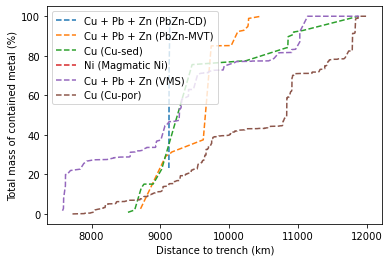

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111, )
ax1.set_xlabel('Distance to trench (km)')
ax1.set_ylabel('Total mass of contained metal (%)')


for sheet in sheets:
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    # cumulative distribution of subduction zone background
    dist = df['distance_to_trench'].to_numpy()
    idx_sort = dist.argsort()
    dist = dist[idx_sort]
    size = size[idx_sort]
    size /= size.sum()
    cumsum_size = np.cumsum(size)
    
    ax1.plot(dist, cumsum_size*100, label=label, linestyle='--')
    
ax1.legend()